In [ ]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient(
    DefaultAzureCredential(), 
    subscription_id="b0e1b0e0-1c1a-4b1a-8c1a-1b1a0b1a1b1a", 
    resource_group_name="ray", 
    workspace="ray"
)

In [18]:
endpoint = ml_client.endpoints.get("text-davinci-003")

In [16]:
# a request using requests
import requests
import json

url = endpoint.scoring_url
headers = {
    "Content-Type": "application/json",
    "api-key": endpoint.primary_key
}
payload = {
    "prompt": "What is your name?",
    "max_tokens": 200,
    "temperature": 1.0
}

r = requests.post(url, headers=headers, json=payload)
data = r.json()
print(data)

{'id': 'cmpl-6aYaMbUqsFAhCzO0cjC7S3TOLds4r', 'object': 'text_completion', 'created': 1674170774, 'model': 'text-davinci-002', 'choices': [{'text': '\n\nMy name is Kaitlyn.', 'index': 0, 'finish_reason': 'stop', 'logprobs': None}], 'usage': {'completion_tokens': 9, 'prompt_tokens': 5, 'total_tokens': 14}}


In [ ]:
import mlflow

# Load model as a PyFuncModel.
model_uri = "./data/6model"
loaded_model = mlflow.pyfunc.load_model(model_uri)

# load test data    
import pandas as pd
test_data = pd.read_csv("./data/1raw/yelp_test.csv")

# Evaluate the model using the test dataset.
test_data

In [ ]:
ratings = loaded_model.predict(test_data)

In [ ]:
(test_data.stars == ratings).mean()

In [ ]:
eval_df = pd.DataFrame({"target": test_data.stars, "prediction": ratings})
# squared_diff(eval_df, None)
((eval_df["prediction"] - eval_df["target"]) ** 2).mean()

In [ ]:
from mlflow.models import make_metric
import numpy as np

def mse(eval_df, _builtin_metrics):
    """
    This example custom metric function creates a metric based on the ``prediction`` and
    ``target`` columns in ``eval_df`.
    """
    return ((eval_df["prediction"] - eval_df["target"]) ** 2).mean()

results = []

for i in range(10):
    result = mlflow.evaluate(
        model_uri,
        test_data,
        targets="stars",
        model_type="classifier",
        evaluators=["default"],
        custom_metrics=[
            make_metric(
                eval_fn=mse,
                greater_is_better=False,
            )
        ]
    )
    print(result.metrics)
    results.append(result.metrics)

results_df = pd.DataFrame(results)

In [ ]:
total_df = pd.concat([total_df, results_df])




In [ ]:
# plot histogram of results.mse
import matplotlib.pyplot as plt
plt.hist(total_df.mse, bins=10)
plt.title("Histogram of MSE")
plt.xlabel("mse")
plt.ylabel("count")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.hist(total_df.f1_score, bins=10)
plt.title("Histogram of f1_score")
plt.xlabel("f1_score")
plt.ylabel("count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(total_df.accuracy_score, bins=10)
plt.title("Histogram of accuracy_score")
plt.xlabel("accuracy_score")
plt.ylabel("count")
plt.show()

In [ ]:
total_df.describe()

In [ ]:
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = "https://aoai.openai.azure.com/"
openai.api_type = "azure"  
openai.api_version = "2022-06-01-preview"

response = openai.Embedding.create(
    input="canine companions say",
    engine="text-similarity-davinci-001")

In [ ]:
len(response.data[0].embedding)

In [ ]:
# load yelp_small.csv
import pandas as pd
yelp_small = pd.read_csv("./data/1raw/yelp.csv")

df = yelp_small[["text"]]


#create tqdm progress bar
from tqdm import tqdm
tqdm.pandas()

scores = []
for text in tqdm(df.text):
    response = openai.Embedding.create(
        input=text,
        engine="text-similarity-davinci-001")
    scores.append(response.data[0].embedding)
scores = np.array(scores)
scores.shape

In [ ]:
import numpy as np
stars = np.array(yelp_small.stars)[:len(scores)]

In [ ]:
np.savez("./data/2features/yelp_davinci.npz", embedding=scores, target=stars)

In [12]:
# load numpy data from npz file
validation = np.load("./data/2feature/validation_mini_ada.npz")
train = np.load("./data/2feature/train_mini_ada.npz")
t_embedding = train['embedding']
t_target = train['target']
v_embedding = validation['embedding']
v_target = validation['target']
print(t_embedding.shape, t_target.shape)
print(v_embedding.shape, v_target.shape)


(29, 1024) (29,)
(7, 1024) (7,)


In [ ]:
# train a pytorch model on the embeddings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class YelpDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y-1
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# load data
x = np.load("./data/2features/yelp_small_text.npy")
y = np.load("./data/2features/yelp_small_stars.npy")

# split into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# create dataset
train_dataset = YelpDataset(x_train, y_train)
test_dataset = YelpDataset(x_test, y_test)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# define model
class YelpModel(nn.Module):
    def __init__(self):
        super(YelpModel, self).__init__()
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 5)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# create model
model = YelpModel()

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train model
for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# test model 
model.eval()
test_loss = 0
correct = 0
print("Testing model")

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

# print loss and accuracy
print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



In [ ]:
files = np.load("./data/2feature/validation")

In [ ]:
files['embedding'], files['target']

In [2]:
import numpy as np
stars = np.load("data/2feature/yelp_curie_stars.npy")
embeddings = np.load("data/2feature/yelp_curie_text.npy")

In [39]:
import numpy as np
# load numpy data from npz file
validation = np.load("./data/2feature/validation_ada.npz")
train = np.load("./data/2feature/train_ada.npz")
t_embedding = train['embedding']
t_target = train['target']
v_embedding = validation['embedding']
v_target = validation['target']
print(t_embedding.shape, t_target.shape)
print(v_embedding.shape, v_target.shape)

(7730, 4096) (7730,)
(1932, 4096) (1932,)


In [42]:
pd.set_option('display.max_colwidth', 200)
import pandas as pd

df_train = pd.DataFrame({"stars":t_target, "embeddings":[x for x in t_embedding]})
df_validation = pd.DataFrame({"stars":t_target, "embeddings":[x for x in t_embedding]})

print(df_train.shape)
print(df_validation.shape)
print(df_train.dtypes)
print(df_validation.dtypes)



(7730, 2)
(7730, 2)
stars          int64
embeddings    object
dtype: object
stars          int64
embeddings    object
dtype: object


In [43]:
# expand the array of embeddings into a dataframe
df_train = pd.DataFrame(t_embedding)
# make sure column names are strings
df_train.columns = ["c"+v for v in df_train.columns.astype(str)]

df_validation = pd.DataFrame(v_embedding)
# make sure column names are strings
df_validation.columns = ["c"+v for v in df_validation.columns.astype(str)]

df_train['stars'] = t_target
df_validation['stars'] = v_target

print(df_train.shape)
print(df_validation.shape)
print(df_train.dtypes)
print(df_validation.dtypes)

df_train.head()

(7730, 4097)
(1932, 4097)
c0       float64
c1       float64
c2       float64
c3       float64
c4       float64
          ...   
c4092    float64
c4093    float64
c4094    float64
c4095    float64
stars      int64
Length: 4097, dtype: object
c0       float64
c1       float64
c2       float64
c3       float64
c4       float64
          ...   
c4092    float64
c4093    float64
c4094    float64
c4095    float64
stars      int64
Length: 4097, dtype: object


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c4087,c4088,c4089,c4090,c4091,c4092,c4093,c4094,c4095,stars
0,-0.009544,-0.004455,-0.006378,0.009879,-0.012505,0.018725,0.004337,-0.004197,0.011248,-0.012142,...,-0.024358,0.004847,0.007724,-0.010680,0.001671,-0.008576,0.007673,0.000609,0.010494,4
1,-0.005431,0.010515,-0.014673,0.002872,-0.018325,0.003439,0.000895,-0.003132,0.000421,-0.016349,...,-0.017454,0.000782,0.025020,-0.001185,0.002793,-0.030545,-0.000150,0.006077,0.021668,3
2,-0.014215,0.006432,-0.007576,0.009017,-0.018202,-0.005967,-0.007248,-0.000912,0.023926,0.015153,...,-0.007328,-0.004717,0.018024,0.018024,-0.012047,-0.024770,-0.014074,0.021055,0.020004,4
3,0.002170,0.005094,-0.004394,0.022045,-0.018361,-0.008075,0.000461,0.009127,-0.010421,0.009888,...,-0.012002,-0.012438,0.010489,-0.010450,0.010829,-0.019447,-0.020959,0.009908,0.004156,4
4,0.009935,0.016374,-0.010495,0.003238,-0.022823,0.010131,-0.024673,0.002537,0.005570,0.021159,...,-0.015449,0.002551,0.021421,0.002554,0.003285,-0.006654,0.005664,0.004145,0.003734,4


In [45]:
df_train.to_parquet("data/2feature/yelp_curie/train/train_curie.parquet")
df_validation.to_parquet("data/2feature/yelp_curie/validation/validation_curie.parquet")

In [ ]:
#Note: The openai-python library support for Azure OpenAI is in preview.import os
import openai
openai.api_type = "azure"
openai.api_base = "https://aoai.openai.azure.com/"
openai.api_version = "2022-06-01-preview"
openai.api_key = os.getenv("OPENAI_API_KEY")

text = "The food was good, but the service was terrible."

prompt=f"Classify the following yelp review into 1 of the following categories: categories: [1, 2, 3, 4, 5]\n\nyelp review: {text} \n\nClassified category:",

response = openai.Completion.create(
  engine="text-davinci-002",
  prompt=[prompt,prompt],
  temperature=0,
  max_tokens=60,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  stop=None
)

response

In [ ]:
import openai
from tqdm import tqdm
def classify_yelp(texts):
    prompts = []
    for text in texts:
      prompts.append(f"Classify the following yelp review into 1 of the following categories: categories: [1, 2, 3, 4, 5]\n\nyelp review: {text} \n\nClassified category:")

    response = openai.Completion.create(
      engine="text-davinci-002",
      prompt=prompts,
      temperature=0,
      max_tokens=60,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=None
    )
    results = [choice['text'].strip() for choice in response['choices']]
    return results

def classify_yelp_batch(texts, batch_size=20):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        results.extend(classify_yelp(texts[i:i+batch_size]))
    return results



In [ ]:

df = pd.read_csv("data/1raw/yelp_test.csv")
df['stars'] = df['stars'].astype(str)

results = classify_yelp_batch(df['text'].values)

df['accurate'] = df['stars'] == results
df.accurate.mean()

In [ ]:
import evaluate
f1 = evaluate.load("f1")

f1.compute(references=df['stars'], predictions=results, average='weighted')

In [ ]:
def calculate_metrics(references, predictions):
    f1 = evaluate.load("f1").compute(references=references, predictions=predictions, average='weighted')
    accuracy = evaluate.load("accuracy").compute(references=references, predictions=predictions)
    precision = evaluate.load("precision").compute(references=references, predictions=predictions, average='weighted')
    recall = evaluate.load("recall").compute(references=references, predictions=predictions, average='weighted')
    # merge the dicts
    metrics = {**f1, **accuracy, **precision, **recall}
    return metrics

In [ ]:
# merge dicts



In [ ]:
calculate_metrics(references=df['stars'], predictions=results)

In [ ]:
df

In [ ]:
os.environ["MLFLOW_TRACKING_URI"] = "azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray"
sweep_run_id = "HD_7e2c2145-561c-4b71-97ea-1f8241482661" 
client = MlflowClient()
sweep = client.get_run(sweep_run_id)
sweep.data

In [ ]:
mlflow_tracking_uri = "azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray"
sweep_run_id = "HD_7e2c2145-561c-4b71-97ea-1f8241482661" 
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri=mlflow_tracking_uri)


In [ ]:
sweep_results = []
sweep = client.get_run(sweep_run_id)
for k, _ in sweep.data.tags.items():
    if k.startswith(sweep_run_id):
        print(k)
        run = client.get_run(k)
        sweep_results.append({**run.data.metrics, **run.data.params})


In [ ]:
sweep_results_df = pd.DataFrame(sweep_results)
sweep_results_df.to_csv("data/7sweep/sweep_results_new.csv", index=False) 

In [ ]:
import pandas as pd
sweep_results_df = pd.read_csv("data/7sweep/sweep_results.csv")
sweep_results_df['accuracy'] = sweep_results_df['classification/accuracy']
sweep_results_df['f1_score'] = sweep_results_df['classification/weighted_f1_score']
# find the best run by model
best_runs = sweep_results_df.groupby("model").apply(lambda x: x.nlargest(1, "f1_score"))
best_runs[[ "accuracy","f1_score"]]

In [ ]:
import pandas as pd
sweep_results_df = pd.read_csv("data/7sweep/sweep_results.csv")
sweep_results_df['accuracy'] = sweep_results_df['classification/accuracy']
sweep_results_df['f1_score'] = sweep_results_df['classification/weighted_f1_score']
# order by f1 score
sweep_results_df = sweep_results_df.sort_values("f1_score", ascending=False)
sweep_results_df.head()

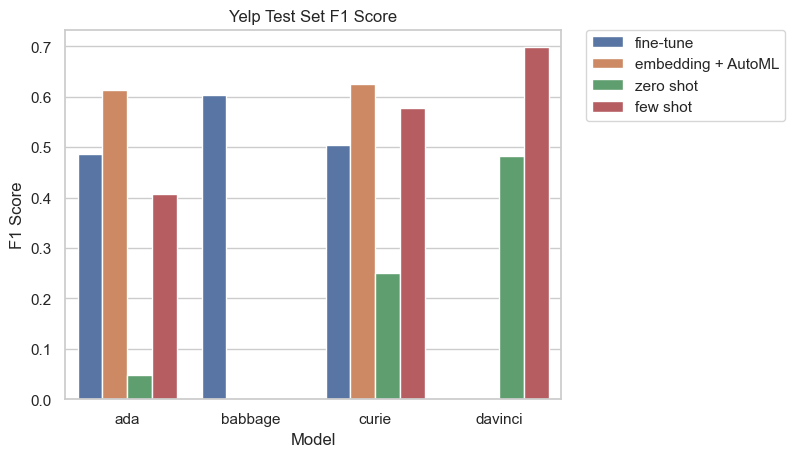

In [54]:
import pandas as pd

df = pd.read_csv("data/7sweep/yelp_test_results.csv")
# sort df by model
df = df.sort_values(by=['Model'])

# plot data in a bar chart
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Model", y="F1 Score", hue="Technique", data=df)
ax.set_title("Yelp Test Set F1 Score")
ax.set_xlabel("Model")
ax.set_ylabel("F1 Score")
# move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#save plot
plt.savefig("images/yelp_test_f1.png", bbox_inches='tight')



In [55]:
job_template = "[{job}](https://ml.azure.com/experiments/id/0a12bb58-a8c2-4215-b82b-5e6b57bbfa47/runs/{job}?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray&tid=72f988bf-86f1-41af-91ab-2d7cd011db47)"
# create a new column with the job link
df.job = df.job.apply(lambda x: job_template.format(job=x))

print(df.to_markdown(index=False))

| Model   | Technique          |   Accuracy |   F1 Score | job                         |
|:--------|:-------------------|-----------:|-----------:|:----------------------------|
| ada     | fine-tune          |   0.5263   |   0.4855   | nan                         |
| ada     | embedding + AutoML |   0.619535 |   0.612792 | musing_cart_wjzb12p2        |
| ada     | zero shot          |   0.1095   |   0.0482   | nan                         |
| ada     | few shot           |   0.4231   |   0.4068   | patient_ship_3dg6gh430b_89  |
| babbage | fine-tune          |   0.6147   |   0.6042   | shy_picture_b0gpxgmn        |
| curie   | zero shot          |   0.2751   |   0.251    | nan                         |
| curie   | embedding + AutoML |   0.628976 |   0.624561 | stoic_screw_jw6bywsn        |
| curie   | fine-tune          |   0.5376   |   0.5041   | nan                         |
| curie   | few shot           |   0.5799   |   0.5768   | jolly_rhythm_cnryl9j3f0_83  |
| davinci | zero shot

In [ ]:
# combine the above plots into one figure
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sweep_results_df.plot.scatter(x='model', y='f1_score', ax=axes[0,0])

sns.regplot(x='n_epochs', y='f1_score', data=sweep_results_df, ax=axes[0,1], scatter=True, lowess=True)
sns.regplot(x='batch_size', y='f1_score', data=sweep_results_df, ax=axes[1,0], scatter=True, lowess=True)
sns.regplot(x='learning_rate_multiplier', y='f1_score', ax=axes[1,1], data=sweep_results_df, scatter=True, lowess=True)
plt.savefig('images/all_scatterplots.png', facecolor='white')


In [ ]:
sweep_results_df.f1_score.describe()

In [ ]:
import matplotlib.pyplot as plt
df = sweep_results_df
# plot histogram of f1_score and save to file
df.f1_score.hist(bins=20)
# add title and labels
plt.title('Histogram of f1_score')
plt.xlabel('f1_score')
plt.ylabel('count')
# save the plot to file f1_score.png
plt.savefig('images/f1_score.png', facecolor='white')

In [ ]:
import openai
openai.api_key = os.environ.get("OPENAI_API_KEY")
openai.api_base = "https://aoai.openai.azure.com/"
openai.api_type = 'azure'  
openai.api_version = "2022-06-01-preview"
deployments = openai.Deployment.list()
print(deployments)

In [ ]:
import pandas as pd
df = pd.read_csv("data/6stats/model_stats.csv")
df

In [ ]:
df[["test_f1", "test_accuracy","classification/weighted_f1_score", "classification/accuracy"]]

In [ ]:
import openai
did = "deployment-c2d69251f246484a9a05a9e7a49ba091"
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = "https://aoai.openai.azure.com/"
openai.api_type = "azure"  
openai.api_version = "2022-06-01-preview"

openai.Deployment.delete(sid=did)

In [ ]:
# create shell command to grep all lines starting with "{'test_f1':"

# create shell command to grep all lines starting with "{'test_f1':"
!grep -E "{'test_f1':" logs.txt > logs2.txt

In [ ]:
import ast
# read text file
with open("logs2.txt", "r") as f:
    lines = f.readlines()

data_array = [] 
for line in lines:
    data_array.append(ast.literal_eval(line))

df = pd.DataFrame(data_array)
df

In [ ]:
df = pd.read_csv("data/6stats/model_stats.csv")
df

In [ ]:
df["diff_f1"] = df["test_f1"] - df["classification/weighted_f1_score"]
df["diff_accuracy"] = df["test_accuracy"] - df["classification/accuracy"]
df[["classification/accuracy", "test_accuracy", "diff_accuracy", "classification/weighted_f1_score", "test_f1", "diff_f1"]]

In [ ]:
# classification/accuracy vs. test_accuracy without regression line
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="classification/accuracy", y="test_accuracy", data=df)
# add the same for f1_score
ax = sns.scatterplot(x="classification/weighted_f1_score", y="test_f1", data=df)
ax.set_title("Classification Accuracy/F1 vs. Test Accuracy/F1")
ax.set_xlabel("Accuracy/F1 from Fine-Tuning")
ax.set_ylabel("Accuracy/F1 from deployed model")

# add legend
plt.legend(labels=['Accuracy', 'F1 Score'])

# add identity line
import numpy as np
x = np.linspace(.3, .65, 100)
y = x
plt.plot(x, y, color='red', linestyle='--')

#save plot
plt.savefig("images/fine_tune_vs_deployed_model_metric.png", bbox_inches='tight')


In [ ]:
diffs = pd.melt(df[["diff_accuracy", "diff_f1"]])

# draw boxplot of both diff_accuracy and diff_f1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y="value", x="variable", data=diffs)
ax.set_title("Difference in Accuracy/F1 Score")
# add scatterplot of diff_accuracy
ax = sns.scatterplot(x="classification/accuracy", y="diff_accuracy", data=df)
# add boxplot of diff_f1 next to it
ax = sns.scatterplot(x="classification/weighted_f1_score", y="diff_f1", data=df)
# save the plot to file
plt.savefig("images/diff_accuracy_f1.png", bbox_inches='tight')


In [ ]:
# plot the difference in accuracy and f1_score as a function of the f1_score and accuracy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="classification/accuracy", y="diff_accuracy", data=df)
# add the same for f1_score
ax = sns.scatterplot(x="classification/weighted_f1_score", y="diff_f1", data=df)
ax.set_title("Difference in Accuracy/F1 vs. Accuracy/F1")
ax.set_xlabel("Accuracy/F1 from Fine-Tuning")
ax.set_ylabel("Difference in Accuracy/F1 from deployed model")
# add regression line
sns.regplot(x="classification/accuracy", y="diff_accuracy", data=df, scatter=False)

# save plot
plt.savefig("images/diff_accuracy_f1_vs_fine_tune_accuracy_f1.png", bbox_inches='tight')


In [ ]:
df = pd.read_csv("data/1raw/yelp_mini.csv")
model_input = pd.DataFrame({"prompt": df["text"], "completion": df["stars"]})
model_input = model_input[:10]
model_input

In [ ]:
import openai, os, requests, json
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = "https://aoai.openai.azure.com/"
openai.api_type = "azure"  
openai.api_version = "2022-06-01-preview"

BATCH_SIZE = 20
api_version="2022-06-01-preview" # hardcode for now
deployment = "best-model"
endpoint = "https://aoai.openai.azure.com/"
api_key = os.environ["OPENAI_API_KEY"]
openai.api_key = api_key

url = endpoint + "openai/deployments/" + deployment + "/completions?api-version=" + api_version
print(f"url: {url}")

payload = {
    "prompt": list(model_input.prompt.values)
}
# ,
#     "max_tokens": 5,
#     "temperature": 0,
#     "top_p": 0,
#     "frequency_penalty": 0
# }  


print(f"sending {len(model_input)} items to url {url}")

r = requests.post(url,
    headers={
        "api-key": api_key,
        "Content-Type": "application/json"
    },
    json = payload
    )
data = r.json()


In [ ]:
df = sweep_results_df[["model", "n_epochs", "batch_size", "learning_rate_multiplier", "f1_score"]]
df = df.sort_values(by="f1_score", ascending=False)
# encode model as a categorical variable
categories = np.sort(df.model.unique())
df["model"] = df["model"] = pd.Categorical(df.model, 
                                            categories=categories)
df["model"] = df["model"].cat.codes


In [ ]:
# build model that predicts f1_score from hyperparameters, then find out which hyperparameters are most important
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# split data into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)

# build model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train.drop(columns=["f1_score"]), train["f1_score"])

# predict on test set
y_pred = model.predict(test.drop(columns=["f1_score"]))
y_true = test["f1_score"]
print(f"mean squared error: {mean_squared_error(y_true, y_pred)}")

# get feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
                axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(train.drop(columns=["f1_score"]).shape[1]):
    print(f"{f + 1}. feature {train.drop(columns=['f1_score']).columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.drop(columns=["f1_score"]).shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train.drop(columns=["f1_score"]).shape[1]), train.drop(columns=["f1_score"]).columns[indices], rotation=90)
plt.xlim([-1, train.drop(columns=["f1_score"]).shape[1]])
plt.show()




In [ ]:
df = pd.read_json("data/1raw/yelp_validation.jsonl", lines=True, orient="records")
df["text"] = df.prompt.apply(lambda x: x[:-7]) 
df["stars"] = df.completion
df[["text","stars"]].to_csv("data/1raw/yelp_validation.csv", index=False)

In [ ]:
import mlflow
import os
os.environ["MLFLOW_TRACKING_URI"] = "azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray"
client = mlflow.tracking.MlflowClient()

In [ ]:
# command job run from CLI
command_job = client.get_run("khaki_rain_h73f692hgq")
print(command_job.data.tags["mlflow.runName"])
print(command_job.info.run_id)
print(command_job.info.run_name)
print(command_job.info.run_uuid)


In [ ]:
sweep_job_in_pipeline = client.get_run("HD_c757d6eb-5412-4644-a235-a0e6ed368884")

print(sweep_job_in_pipeline.data.tags["mlflow.runName"])
print(sweep_job_in_pipeline.info.run_id)
print(sweep_job_in_pipeline.info.run_name)
print(sweep_job_in_pipeline.info.run_uuid)

In [ ]:

sweep_job_child = client.get_run("HD_c757d6eb-5412-4644-a235-a0e6ed368884_15")

print(sweep_job_child.data.tags["mlflow.runName"])
print(sweep_job_child.info.run_id)
print(sweep_job_child.info.run_name)
print(sweep_job_child.info.run_uuid)



In [ ]:
parent_run = "HD_c757d6eb-5412-4644-a235-a0e6ed368884"
# get all children of parent_run
children = client.search_runs(experiment_ids=[], filter_string=f"tags.mlflow.parentRunId = '{parent_run}'")

for child in children:
    print(child.info.run_uuid)
    #print(child.data.metrics)

child

In [ ]:
client = mlflow.tracking.MlflowClient(tracking_uri="azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray")
experiment_id = client.get_experiment_by_name("openai").experiment_id

children = client.search_runs(experiment_ids=[experiment_id])

for child in children:
    print(child.info.run_uuid)





In [ ]:
client = mlflow.tracking.MlflowClient(tracking_uri="azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray")
runs = client.search_runs(experiment_ids=[])
for run in runs:
    print(run.info.run_uuid)


In [ ]:
import pandas as pd
df = pd.read_csv("data/1raw/yelp_small.csv")
df= df[["text", "stars"]]
# pick the first 50 rows
df = df.iloc[:50]
df.to_json("data/1raw/yelp_small.jsonl", orient="records", lines=True)

In [ ]:
import pandas as pd
prompts = pd.read_csv("data/1prompts/prompts3.csv").prompt.values
prompts[0]

In [ ]:
print(prompts[2])

In [ ]:
from mlflow.tracking import MlflowClient
def load_metrics_from_sweep(sweep_id, metrics, params):
    mlflow_tracking_uri = "azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray"
    client = MlflowClient(tracking_uri=mlflow_tracking_uri)
    children = client.search_runs(experiment_ids=[], filter_string=f"tags.mlflow.parentRunId = '{sweep_id}'")
    results = []
    for child in children:
        try:
            results.append({ metric: child.data.metrics[metric] for metric in metrics})
            results[-1].update({ param: child.data.params[param] for param in params})
            results[-1].update({ "run_id": child.info.run_uuid})
            if child.info.run_uuid == "placid_energy_hzkj1x77wl_85":
                print(results[-1])
        except KeyError:
            pass
    return pd.DataFrame(results)



In [ ]:
df1 = load_metrics_from_sweep("strong_tree_3w05fl03gg", ["f1"], ["examples_number"])
df2 = load_metrics_from_sweep("salmon_peach_4n72lj3s4x", ["f1"], ["examples_number"])


In [ ]:
df3 = load_metrics_from_sweep("placid_energy_hzkj1x77wl", ["f1"], ["examples_number"])

In [ ]:
# find run with highest f1 for each examples_number
# merge the two dataframes
#dfx = pd.concat([df1, df2, df3])
dfx = df3
df = dfx.sort_values("f1", ascending=False).drop_duplicates("examples_number")
df

In [ ]:
# find the top 3 f1 scores by example_number
df = dfx.sort_values("f1", ascending=False).groupby("examples_number").head(3)
df = df.sort_values("examples_number")
# # filter for examples_number == 1
# df = df[df.examples_number == 1]
# df.head(3)
df

In [ ]:
# find run with lowest f1 for each examples_number
df = dfx.sort_values("f1", ascending=True).drop_duplicates("examples_number")
df

In [ ]:
0.696633-0.625734

In [ ]:
# merge the two dataframes
df = pd.concat([df1, df2, df3])

df.examples_number = df.examples_number.astype(int)
df = df.sort_values("f1", ascending=False)

# scatterplot examples_number vs f1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="examples_number", y="f1", data=df, s=15)
# scatterplot with smaller dots
# ax = sns.scatterplot(x="examples_number", y="f1", data=df, s=10)

ax.set_title("F1 vs the number of examples in the prompt")
ax.set_xlabel("examples_number")
ax.set_ylabel("f1")
# sns.regplot(x="examples_number", y="f1", data=df, scatter=False, color=".2", lowess=True)
# for i, row in df.groupby("examples_number").mean().iterrows():
#     ax.text(i+0.1, row.f1, f"{row.f1:.3f}", horizontalalignment='left', size='small', color='grey', weight='semibold')
#     ax.scatter(i, row.f1, marker="D", color="black", s=10)
plt.savefig("images/few_shot_examples_vs_f1.png", bbox_inches='tight')

In [ ]:
# find if the distributions for the different examples_number are stat sig different
from scipy.stats import ttest_ind
import numpy as np
example_numbers = df.examples_number.unique()
example_numbers.sort()
p_values = np.empty((len(example_numbers),len(example_numbers)))
for i in example_numbers:
    for j in example_numbers:
        t, p = ttest_ind(df[df.examples_number == i].f1, df[df.examples_number == j].f1)
        #print(f"ttest for examples_number == {i} vs examples_number == {j}: t={t:.3f}, p={p:.3f}")
        # find index of i in examples_numbers
        i_index = np.where(example_numbers == i)[0][0]
        j_index = np.where(example_numbers == j)[0][0]
        p_values[i_index,j_index] = p

# label the rows and columns

print(p_values)

pv_df = pd.DataFrame(p_values, index=example_numbers, columns=example_numbers)

print(pv_df.to_markdown())





In [ ]:
#df = load_metrics_from_sweep("kind_lion_r4mdz5pnrt", ["f1"], ["temperature"])
#df.temperature = df.temperature.astype(float)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="temperature", y="f1", data=df)
ax.set_title("F1 score variance increases with Temperature")
ax.set_xlabel("Temperature")
ax.set_ylabel("f1")
# add regression line
#sns.regplot(x="temperature", y="f1", data=df, scatter=False)
# add loess line
#sns.regplot(x="temperature", y="f1", data=df, scatter=False, lowess=True)
# label average f1 for each temperature connected by a line
for i, row in df.groupby("temperature").mean().iterrows():
    ax.text(i+0.01, row.f1, f"{row.f1:.3f}", horizontalalignment='left', size='small', color='grey', weight='semibold')
    ax.scatter(i, row.f1, marker="D", color="black", s=10)




plt.savefig("images/zero_shot_temperature_vs_f1.png", bbox_inches='tight')



In [ ]:
for i, row  in df.groupby("temperature").mean().iterrows():
    print(row.value(), row.f1)

row

In [ ]:
row.values[0]

In [ ]:
client = MlflowClient(tracking_uri=mlflow_tracking_uri)
children2 = client.search_runs(experiment_ids=[], 
                              filter_string=f"tags.mlflow.parentRunId = 'kind_lion_r4mdz5pnrt'", 
                              order_by=["info.start_time ASC"])
len(children2)

In [ ]:
# merge children1 and children2
children = children1 + children2
len(children)



In [ ]:
metrics = ['f1']
params = ['temperature']
results = []
for child in children:
    try:
        results.append({ metric: child.data.metrics[metric] for metric in metrics})
        results[-1].update({ param: child.data.params[param] for param in params})
    except KeyError:
        pass
df = pd.DataFrame(results)

In [ ]:
# convert temperature to float
df.temperature = df.temperature.astype(float)

# remove duplicates from df
df = df.drop_duplicates(subset=['f1'], keep='first')

In [ ]:
pr = pd.read_csv("data/1prompts/few_shot_prompts.csv")
pr

In [ ]:
reviews.stars.hist()

In [ ]:
examples = [
  {
    "n": 1,
    "stars": "2",
    "review": "I was really disappointed with the food. The service was good, but the food was not good at all. I would not recommend this place to anyone."
  },
  {
    "n": 2,
    "stars": "5",
    "review": "I love this place. The food is amazing and the service is great. I would recommend this place to anyone."
  },
  {
    "n": 3,
    "stars": "1",
    "review": "I was really disappointed with the food. The service was good, but the food was not good at all. I would not recommend this place to anyone."
  },
  {
    "n": 4,
    "stars": "3",
    "review": "The food was mediocre. The service was good, but the food was not good at all. I would not recommend this place to anyone."
  }   
]

In [ ]:
pr = pd.read_csv("data/1prompts/few_shot_prompts.csv")
template=pr.template[0]
prefix=pr.prefix[0]
suffix=pr.suffix[0]


In [ ]:
from langchain import PromptTemplate, FewShotPromptTemplate

example_prompt = PromptTemplate(input_variables=["n", "review", "stars"], template=template)

print(example_prompt.format(**examples[0]))

In [ ]:
prompt = FewShotPromptTemplate(
    prefix=prefix,
    examples=examples, 
    example_prompt=example_prompt, 
    suffix=suffix, 
    input_variables=["text"]
)

print(prompt.format(text="Don't go there"))

In [ ]:
examples_df = pd.read_csv("data/1raw/yelp_small.csv")
examples_df.sample(1, random_state=43)

In [ ]:
def get_examples(examples_file, examples_number, seed, prompt_column, completion_column):
    examples_df = pd.read_csv(examples_file)
    
    examples = []
    for i in range(examples_number):
        stars = i%5 + 1
        while True:
            example = examples_df.sample(n=examples_number, ignore_index=True, random_state=seed).iloc[0]
            seed = seed+1
            if example[completion_column] == stars:
                break
        examples.append({"n": i+1, "review": example[prompt_column], "stars": example[completion_column]})
    return examples


get_examples("data/1raw/yelp_small.csv", 4, 43, "text", "stars")

In [ ]:
def get_examples(examples_file, examples_number, seed, prompt_column, completion_column):
    examples_df = pd.read_csv(examples_file)
    
    examples = []
    bucket = set()
    for i in range(examples_number):
        while True:
            example = examples_df.sample(n=examples_number, ignore_index=True, random_state=seed).iloc[0]
            seed = seed+1
            if not example[completion_column] in bucket:
                bucket.add(example[completion_column])
                break
        examples.append({"n": i+1, "review": example[prompt_column], "stars": example[completion_column]})

        if len(bucket) == 5:
            bucket = set()
    return examples


examples = get_examples("data/1raw/yelp_small.csv", 9, 43, "text", "stars")
[example["stars"] for example in examples]

In [ ]:
yelp_df = pd.read_csv("data/1raw/yelp.csv")

# split into 20 buckets 
yelp_df["bucket"] = yelp_df.index % 20

# save each bucket to a file
for bucket in yelp_df.bucket.unique():
    yelp_df[yelp_df.bucket == bucket].to_csv(f"data/1raw/yelp_{bucket}.csv", index=False)

    


In [ ]:
from mlflow.tracking import MlflowClient
def load_metrics(metrics, params):
    mlflow_tracking_uri = "azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/ray/providers/Microsoft.MachineLearningServices/workspaces/ray"
    client = MlflowClient(tracking_uri=mlflow_tracking_uri)
    children = client.search_runs(experiment_ids=[], order_by=["info.start_time DESC"], max_results=10)
    results = []
    for child in children:
        try:
            results.append({ metric: child.data.metrics[metric] for metric in metrics})
            results[-1].update({ param: child.data.params[param] for param in params})
            results[-1].update({ "run_id": child.info.run_uuid})
        except KeyError:
            pass
    return pd.DataFrame(results)

df = load_metrics(["f1"], ["example_number"])
df

In [ ]:
df = pd.read_json("data/1raw/yelp_validation.jsonl", lines=True, orient="records")
df

In [37]:
# read validation file as df
df = pd.read_csv("data/1raw/yelp_validation.csv")
df.shape

(532, 2)

In [38]:

def split_dataframe(df, ratio):
    part_train = df.sample(frac = ratio)
    part_validation = df.drop(part_train.index)
    return part_train, part_validation

# split df into train and validation
train_df, validation_df = split_dataframe(df, 0.8)
train_df.shape, validation_df.shape

((426, 2), (106, 2))

In [3]:
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.llms import OpenAI
llm = OpenAI(temperature=0)
tools = load_tools(["serpapi", "llm-math"], llm=llm)
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)

In [13]:
agent.run("what is the square root of the cost of taxi ride from downtown seattle to the airport? Show both the price, the distance.")



> Entering new AgentExecutor chain...
['Answer the following questions as best you can. You have access to the following tools:\n\nSearch: A search engine. Useful for when you need to answer questions about current events. Input should be a search query.\nCalculator: Useful for when you need to answer questions about math.\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [Search, Calculator]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: what is the square root of the cost of taxi ride from downtown seattle to the airport? Show both the price, the distance.\nThought:']
[[Generation(text=' I need to find the cost of the taxi ride and the di

'The cost of the taxi ride from downtown Seattle to the airport is $40 and the distance is 14 miles. The square root of the cost is 6.324555320336759.'